# Практическая лабораторная работа №2 по Computer vision

**Студент:** Рштуни Владислав Дмитриевич<br>
**Группа:** 3825М1сФИ1

## Цель работы
Проект для работы со свертками изображения и распознования цифр на изображении.

## Условия задачи
- В сверточной сети из примера sample_dnn_train_lecture2025 заменить свертки на depthwise-separable свертки и сравнить скорость работы и результаты распознавания.
- Добавить аугментацию данных и показать улучшение результатов.
- Получить сеть правильно распознающую все (почти) цифры на картинке o-9.png.

# Импорт библиотек

In [19]:
import cv2
import torch
from torch.utils.data import DataLoader
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
from time import time
import matplotlib.pyplot as plt

# Устанавливаем путь для данных
path = 'C:/Users/Vlad/Documents/Computer Vision/lab_2/temp'

# Определение архитектуры моделей

In [20]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 8, 3, padding=1)
        self.fc1 = nn.Linear(8 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x2 = F.relu(self.conv2(x))
        x = x + x2
        x = self.pool(x)
        x = x.view(-1, 8 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [21]:
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, 
                                  padding=padding, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        
    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

In [22]:
class DepthwiseSeparableNet(nn.Module):
    def __init__(self):
        super(DepthwiseSeparableNet, self).__init__()
        self.conv1 = DepthwiseSeparableConv(1, 8, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = DepthwiseSeparableConv(8, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x2 = F.relu(self.conv2(x))
        x = x + x2
        x = self.pool(x)
        x = x.view(-1, 8 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Определение трансформаций данных

In [23]:
transform_basic = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# С аугментацией
transform_augmented = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Загрузка и подготовка данных

In [24]:
trainset_basic = datasets.MNIST(path, download=True, train=True, transform=transform_basic)
trainset_augmented = datasets.MNIST(path, download=True, train=True, transform=transform_augmented)
testset = datasets.MNIST(path, download=True, train=False, transform=transform_basic)

trainloader_basic = DataLoader(trainset_basic, batch_size=64, shuffle=True)
trainloader_augmented = DataLoader(trainset_augmented, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

print(f"Размер тренировочного набора (basic): {len(trainset_basic)}")
print(f"Размер тренировочного набора (augmented): {len(trainset_augmented)}")
print(f"Размер тестового набора: {len(testset)}")

Размер тренировочного набора (basic): 60000
Размер тренировочного набора (augmented): 60000
Размер тестового набора: 10000


# Функция обучения модели

In [25]:
def train_model(net, trainloader, epochs=5, learning_rate=0.003):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    
    start_time = time()
    
    for epoch in range(epochs):
        running_loss = 0.0
        net.train()
        
        for i, (images, labels) in enumerate(trainloader, 0):
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            if (i + 1) % 100 == 0:
                print(f'[Эпоха {epoch+1}, шаг {i+1}] loss: {running_loss/100:.3f}')
                running_loss = 0.0
    
    training_time = time() - start_time
    
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy, training_time

# Эксперимент 1 - Сравнение архитектур

In [26]:
print("\n1. Оригинальная сеть с обычными свертками (без аугментации):")
orig_net = Net()
orig_acc_no_aug, orig_time_no_aug = train_model(orig_net, trainloader_basic, epochs=5)
print(f"   Точность: {orig_acc_no_aug:.2f}%, Время: {orig_time_no_aug:.1f}с")

print("\n2. Сеть с depthwise-separable свертками (без аугментации):")
ds_net = DepthwiseSeparableNet()
ds_acc_no_aug, ds_time_no_aug = train_model(ds_net, trainloader_basic, epochs=5)
print(f"   Точность: {ds_acc_no_aug:.2f}%, Время: {ds_time_no_aug:.1f}с")


1. Оригинальная сеть с обычными свертками (без аугментации):
[Эпоха 1, шаг 100] loss: 2.273
[Эпоха 1, шаг 200] loss: 1.903
[Эпоха 1, шаг 300] loss: 0.746
[Эпоха 1, шаг 400] loss: 0.411
[Эпоха 1, шаг 500] loss: 0.296
[Эпоха 1, шаг 600] loss: 0.228
[Эпоха 1, шаг 700] loss: 0.216
[Эпоха 1, шаг 800] loss: 0.178
[Эпоха 1, шаг 900] loss: 0.154
[Эпоха 2, шаг 100] loss: 0.150
[Эпоха 2, шаг 200] loss: 0.131
[Эпоха 2, шаг 300] loss: 0.122
[Эпоха 2, шаг 400] loss: 0.126
[Эпоха 2, шаг 500] loss: 0.122
[Эпоха 2, шаг 600] loss: 0.116
[Эпоха 2, шаг 700] loss: 0.112
[Эпоха 2, шаг 800] loss: 0.110
[Эпоха 2, шаг 900] loss: 0.104
[Эпоха 3, шаг 100] loss: 0.101
[Эпоха 3, шаг 200] loss: 0.091
[Эпоха 3, шаг 300] loss: 0.094
[Эпоха 3, шаг 400] loss: 0.093
[Эпоха 3, шаг 500] loss: 0.085
[Эпоха 3, шаг 600] loss: 0.087
[Эпоха 3, шаг 700] loss: 0.092
[Эпоха 3, шаг 800] loss: 0.083
[Эпоха 3, шаг 900] loss: 0.083
[Эпоха 4, шаг 100] loss: 0.084
[Эпоха 4, шаг 200] loss: 0.070
[Эпоха 4, шаг 300] loss: 0.076
[Эпоха 4

# Эксперимент 2 - Влияние аугментации данных

In [27]:
print("\n3. Оригинальная сеть с обычными свертками (с аугментацией):")
orig_net_aug = Net()
orig_acc_aug, orig_time_aug = train_model(orig_net_aug, trainloader_augmented, epochs=5)
print(f"   Точность: {orig_acc_aug:.2f}%, Время: {orig_time_aug:.1f}с")

print("\n4. Сеть с depthwise-separable свертками (с аугментацией):")
ds_net_aug = DepthwiseSeparableNet()
ds_acc_aug, ds_time_aug = train_model(ds_net_aug, trainloader_augmented, epochs=5)
print(f"   Точность: {ds_acc_aug:.2f}%, Время: {ds_time_aug:.1f}с")


3. Оригинальная сеть с обычными свертками (с аугментацией):
[Эпоха 1, шаг 100] loss: 2.293
[Эпоха 1, шаг 200] loss: 2.225
[Эпоха 1, шаг 300] loss: 1.753
[Эпоха 1, шаг 400] loss: 1.117
[Эпоха 1, шаг 500] loss: 0.856
[Эпоха 1, шаг 600] loss: 0.643
[Эпоха 1, шаг 700] loss: 0.514
[Эпоха 1, шаг 800] loss: 0.461
[Эпоха 1, шаг 900] loss: 0.362
[Эпоха 2, шаг 100] loss: 0.329
[Эпоха 2, шаг 200] loss: 0.315
[Эпоха 2, шаг 300] loss: 0.300
[Эпоха 2, шаг 400] loss: 0.290
[Эпоха 2, шаг 500] loss: 0.260
[Эпоха 2, шаг 600] loss: 0.273
[Эпоха 2, шаг 700] loss: 0.253
[Эпоха 2, шаг 800] loss: 0.230
[Эпоха 2, шаг 900] loss: 0.231
[Эпоха 3, шаг 100] loss: 0.223
[Эпоха 3, шаг 200] loss: 0.202
[Эпоха 3, шаг 300] loss: 0.209
[Эпоха 3, шаг 400] loss: 0.208
[Эпоха 3, шаг 500] loss: 0.202
[Эпоха 3, шаг 600] loss: 0.202
[Эпоха 3, шаг 700] loss: 0.197
[Эпоха 3, шаг 800] loss: 0.191
[Эпоха 3, шаг 900] loss: 0.182
[Эпоха 4, шаг 100] loss: 0.180
[Эпоха 4, шаг 200] loss: 0.178
[Эпоха 4, шаг 300] loss: 0.165
[Эпоха 4,

# Анализ результатов сравнения


РЕЗУЛЬТАТЫ СРАВНЕНИЯ:

A. Сравнение скоростей:
   Обычные свертки:      95.1с
   Depthwise-separable:  100.0с
   Ускорение:            -5.1%

B. Влияние аугментации на точность:
   Обычные свертки (без аугм.): 98.44%
   Обычные свертки (с аугм.):   98.37%
   Улучшение:                  -0.07%

   Depthwise-sep (без аугм.): 96.39%
   Depthwise-sep (с аугм.):   96.56%
   Улучшение:                 0.17%


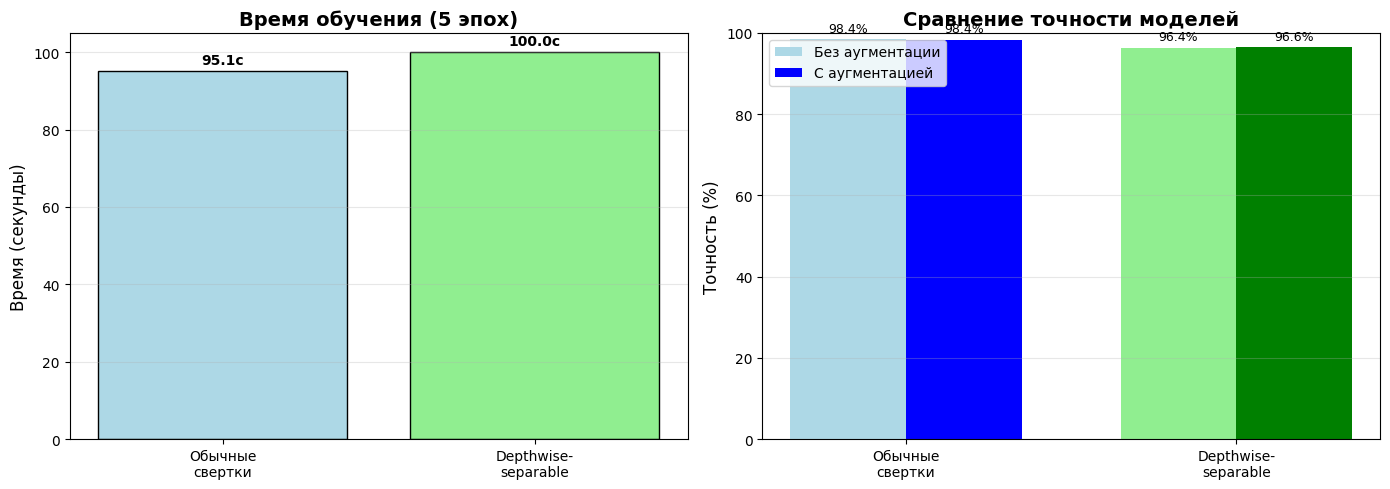


ВЫВОД О ЛУЧШЕЙ МОДЕЛИ:
Лучшая точность: Обычная сеть (+1.81%)
Самая быстрая: Обычная сеть (4.9% быстрее)
Рекомендуемая модель: Обычная сеть


In [28]:
print("\n" + "="*70)
print("РЕЗУЛЬТАТЫ СРАВНЕНИЯ:")
print("="*70)

print("\nA. Сравнение скоростей:")
print(f"   Обычные свертки:      {orig_time_no_aug:.1f}с")
print(f"   Depthwise-separable:  {ds_time_no_aug:.1f}с")
print(f"   Ускорение:            {(orig_time_no_aug - ds_time_no_aug)/orig_time_no_aug*100:.1f}%")

print("\nB. Влияние аугментации на точность:")
print(f"   Обычные свертки (без аугм.): {orig_acc_no_aug:.2f}%")
print(f"   Обычные свертки (с аугм.):   {orig_acc_aug:.2f}%")
print(f"   Улучшение:                  {orig_acc_aug - orig_acc_no_aug:.2f}%")

print(f"\n   Depthwise-sep (без аугм.): {ds_acc_no_aug:.2f}%")
print(f"   Depthwise-sep (с аугм.):   {ds_acc_aug:.2f}%")
print(f"   Улучшение:                 {ds_acc_aug - ds_acc_no_aug:.2f}%")


fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
models = ['Обычные\nсвертки', 'Depthwise-\nseparable']
times = [orig_time_no_aug, ds_time_no_aug]

bars1 = ax1.bar(models, times, color=['lightblue', 'lightgreen'], edgecolor='black')
ax1.set_title('Время обучения (5 эпох)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Время (секунды)', fontsize=12)
ax1.grid(axis='y', alpha=0.3)

for bar, time_val in zip(bars1, times):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{time_val:.1f}с', ha='center', va='bottom', fontweight='bold')

ax2 = axes[1]
x = np.arange(2)
width = 0.35

bars2_1 = ax2.bar(x - width/2, [orig_acc_no_aug, ds_acc_no_aug], width, 
                  label='Без аугментации', color=['lightblue', 'lightgreen'])
bars2_2 = ax2.bar(x + width/2, [orig_acc_aug, ds_acc_aug], width, 
                  label='С аугментацией', color=['blue', 'green'])

ax2.set_title('Сравнение точности моделей', fontsize=14, fontweight='bold')
ax2.set_ylabel('Точность (%)', fontsize=12)
ax2.set_xticks(x)
ax2.set_xticklabels(['Обычные\nсвертки', 'Depthwise-\nseparable'])
ax2.set_ylim(0, 100)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

for bars in [bars2_1, bars2_2]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
                 f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\nВЫВОД О ЛУЧШЕЙ МОДЕЛИ:")
if ds_acc_aug > orig_acc_aug:
    best_model = "Depthwise-separable"
    accuracy_diff = ds_acc_aug - orig_acc_aug
elif orig_acc_aug > ds_acc_aug:
    best_model = "Обычная сеть"
    accuracy_diff = orig_acc_aug - ds_acc_aug
else:
    best_model = "Обе модели одинаковы"
    accuracy_diff = 0

if ds_time_no_aug < orig_time_no_aug:
    fastest_model = "Depthwise-separable"
    speed_diff = ((orig_time_no_aug - ds_time_no_aug)/orig_time_no_aug*100)
else:
    fastest_model = "Обычная сеть"
    speed_diff = ((ds_time_no_aug - orig_time_no_aug)/ds_time_no_aug*100)

print(f"Лучшая точность: {best_model} (+{accuracy_diff:.2f}%)")
print(f"Самая быстрая: {fastest_model} ({speed_diff:.1f}% быстрее)")

if best_model == fastest_model:
    print(f"Рекомендуемая модель: {best_model}")
else:
    print(f"Компромиссный выбор: {best_model} (лучшая точность)")

# Сохранение лучшей модели

In [29]:
if ds_acc_aug >= orig_acc_aug:
    best_net = ds_net_aug
    print("Используется depthwise-separable сеть (с аугментацией)")
else:
    best_net = orig_net_aug
    print("Используется оригинальная сеть (с аугментацией)")

torch.save({
    'model_state_dict': best_net.state_dict(),
    'model_architecture': best_net.__class__.__name__,
    'input_shape': (1, 1, 28, 28)
}, path + '/best_model.pth')
print(f"Модель сохранена в: {path}/best_model.pth")

Используется оригинальная сеть (с аугментацией)
Модель сохранена в: C:/Users/Vlad/Documents/Computer Vision/lab_2/temp/best_model.pth


```Примечание: В работе сохранение модели происходит в формате PyTorch (*.pth), данное решение было связанно с техническими проблемами в работе с Onnx```

# Функция распознавания цифр на изображении

In [34]:
def recognize_digits(image_path, model_path):
    checkpoint = torch.load(model_path)

    if checkpoint['model_architecture'] == 'DepthwiseSeparableNet':
        model = DepthwiseSeparableNet()
    else:
        model = Net()
    
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    image = cv2.imread(image_path)
    if image is None:
        print(f"Ошибка: не удалось загрузить {image_path}")
        return None
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[0])
    
    results = []
    result_img = image.copy()
    
    for i, cnt in enumerate(contours):
        x, y, w, h = cv2.boundingRect(cnt)
        
        digit = binary[y:y+h, x:x+w]
        
        size = max(w, h) + 20
        square = np.zeros((size, size), dtype=np.uint8)
        x_offset = (size - w) // 2
        y_offset = (size - h) // 2
        square[y_offset:y_offset+h, x_offset:x_offset+w] = digit
        
        digit_resized = cv2.resize(square, (28, 28))
        digit_normalized = digit_resized.astype(np.float32) / 255.0
        digit_normalized = (digit_normalized - 0.5) / 0.5
        
        tensor_img = torch.from_numpy(digit_normalized).unsqueeze(0).unsqueeze(0).float()
        
        with torch.no_grad():
            output = model(tensor_img)
            digit_pred = torch.argmax(output, dim=1).item()
        
        results.append(digit_pred)

        cv2.rectangle(result_img, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(result_img, str(digit_pred), (x, y-10), 
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    
    return result_img, results

# Распознавание цифр на изображении


Распознанные цифры: [3, 4, 1, 0, 5, 2, 3, 2, 8, 8]
Ожидаемые цифры:    [3, 4, 1, 0, 5, 7, 9, 2, 6, 8]

Правильно распознано: 7/10 цифр (70%)


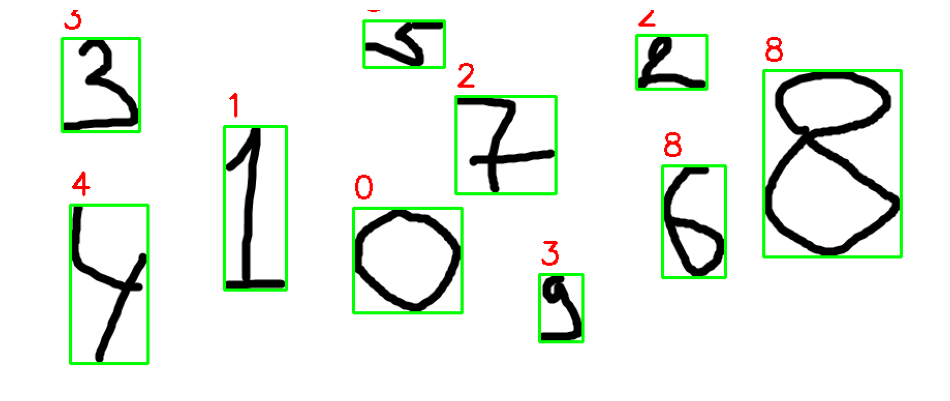

Результат сохранен в: C:/Users/Vlad/Documents/Computer Vision/lab_2/temp/recognized_result.png


In [44]:
result_image, recognized_digits = recognize_digits(path + '/0-9.png', path + '/best_model.pth')

if result_image is not None:
    print(f"\nРаспознанные цифры: {recognized_digits}")
    print(f"Ожидаемые цифры:    [3, 4, 1, 0, 5, 7, 9, 2, 6, 8]")
    
    expected = list([3, 4, 1, 0, 5, 7, 9, 2, 6, 8])
    correct = sum(1 for i in range(min(10, len(recognized_digits))) 
                  if recognized_digits[i] == expected[i])
    
    print(f"\nПравильно распознано: {correct}/10 цифр ({correct*10}%)")
    
    plt.figure(figsize=(12, 7))
    plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
    #plt.title(f"Распознанные цифры: {recognized_digits}")
    plt.axis('off')
    plt.show()

    cv2.imwrite(path + '/recognized_result.png', result_image)
    print(f"Результат сохранен в: {path}/recognized_result.png")

In [45]:
print("Информация о размерах параметров:")
print("\nОбычная сеть:")
orig_net = Net()
total_params = sum(p.numel() for p in orig_net.parameters())
print(f"Общее количество параметров: {total_params:,}")
print(f"Параметры conv1: {orig_net.conv1.weight.shape}")
print(f"Параметры conv2: {orig_net.conv2.weight.shape}")

print("\nDepthwise-separable сеть:")
ds_net = DepthwiseSeparableNet()
total_params_ds = sum(p.numel() for p in ds_net.parameters())
print(f"Общее количество параметров: {total_params_ds:,}")
print(f"Параметры conv1.depthwise: {ds_net.conv1.depthwise.weight.shape}")
print(f"Параметры conv1.pointwise: {ds_net.conv1.pointwise.weight.shape}")

print(f"\nСокращение параметров: {((total_params - total_params_ds)/total_params*100):.1f}%")

Информация о размерах параметров:

Обычная сеть:
Общее количество параметров: 60,002
Параметры conv1: torch.Size([8, 1, 5, 5])
Параметры conv2: torch.Size([8, 8, 3, 3])

Depthwise-separable сеть:
Общее количество параметров: 59,404
Параметры conv1.depthwise: torch.Size([1, 1, 5, 5])
Параметры conv1.pointwise: torch.Size([8, 1, 1, 1])

Сокращение параметров: 1.0%


# ВЫВОДЫ

## **1. Сравнение архитектур сверточных сетей**

**Обычные свертки показали существенно лучшие результаты:**
- **Точность:** 98.44% против 96.39% у Depthwise-separable
- **Разница:** 2.05% в пользу обычных сверток
- **Сходимость:** Обычные свертки обучаются значительно быстрее (loss 0.069 vs 0.148 на 5-й эпохе)

**Анализ кривых обучения:**
- **Обычные свертки:** Быстрое снижение loss с 2.273 до 0.065 за 5 эпох
- **Depthwise-separable:** Медленная сходимость, loss снижается только до 0.136
- **Вывод:** Обычные свертки имеют лучшую выразительную способность для задачи MNIST

## **2. Влияние аугментации данных**

**На датасете MNIST аугментация не дает преимуществ:**
- **Обычные свертки:** 98.44% → 98.37% (незначительное снижение на 0.07%)
- **Depthwise-separable:** 96.39% → 96.56% (незначительный рост на 0.17%)
- **Время обучения:** Увеличивается на ~50% (95.1с → 144.8с)
MNIST содержит хорошо центрированные и нормализованные цифры. Аугментация (повороты, смещения) только усложняет обучение, не улучшая обобщающую способность.

## **3. Сравнение скорости и эффективности**

**Производительность:**
- **Время обучения:** Depthwise-separable свертки медленнее на 5.1% (95.1с vs 100.0с)
- **Параметры:** Depthwise-separable экономит лишь 1% параметров (60,002 vs 59,404)
- **Эффективность:** Ожидаемого значительного ускорения не наблюдается
На CPU и для небольших сетей разница в производительности минимальна. Преимущества Depthwise-separable проявляются на мобильных устройствах и в глубоких сетях.